# CICY4: GRU-based for h11, h21, h31, h22

In [1]:
import numpy as np
import os as os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set_style("darkgrid")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

In [2]:
# load data
path = '/kaggle/input/calabi-yau-cicy-4-folds'
conf = np.load(os.path.join(path, 'conf.npy'))
hodge = np.load(os.path.join(path, 'hodge.npy'))
direct = np.load(os.path.join(path, 'direct.npy'))
conf.shape, hodge.shape, direct.shape

((921497, 16, 20), (921497, 4), (921497,))

In [3]:
X = conf
h11 = hodge[:,0]
h21 = hodge[:,1]
h22 = hodge[:,3]
h31 = hodge[:,2]
h11max = np.max(hodge[:,0])
h11min = np.min(hodge[:,0])
print(f'Max h11: {h11max}, Min h11: {h11min} ')
h21max = np.max(hodge[:,1])
h21min = np.min(hodge[:,1])
print(f'Max h21: {h21max}, Min h21: {h21min} ')
h31max = np.max(hodge[:,2])
h31min = np.min(hodge[:,2])
print(f'Max h31: {h31max}, Min h31: {h31min} ')
h22max = np.max(hodge[:,3])
h22min = np.min(hodge[:,3])
print(f'Max h22: {h22max}, Min h22: {h22min} ')

Max h11: 24, Min h11: 0 
Max h21: 33, Min h21: 0 
Max h31: 426, Min h31: 0 
Max h22: 1752, Min h22: 0 


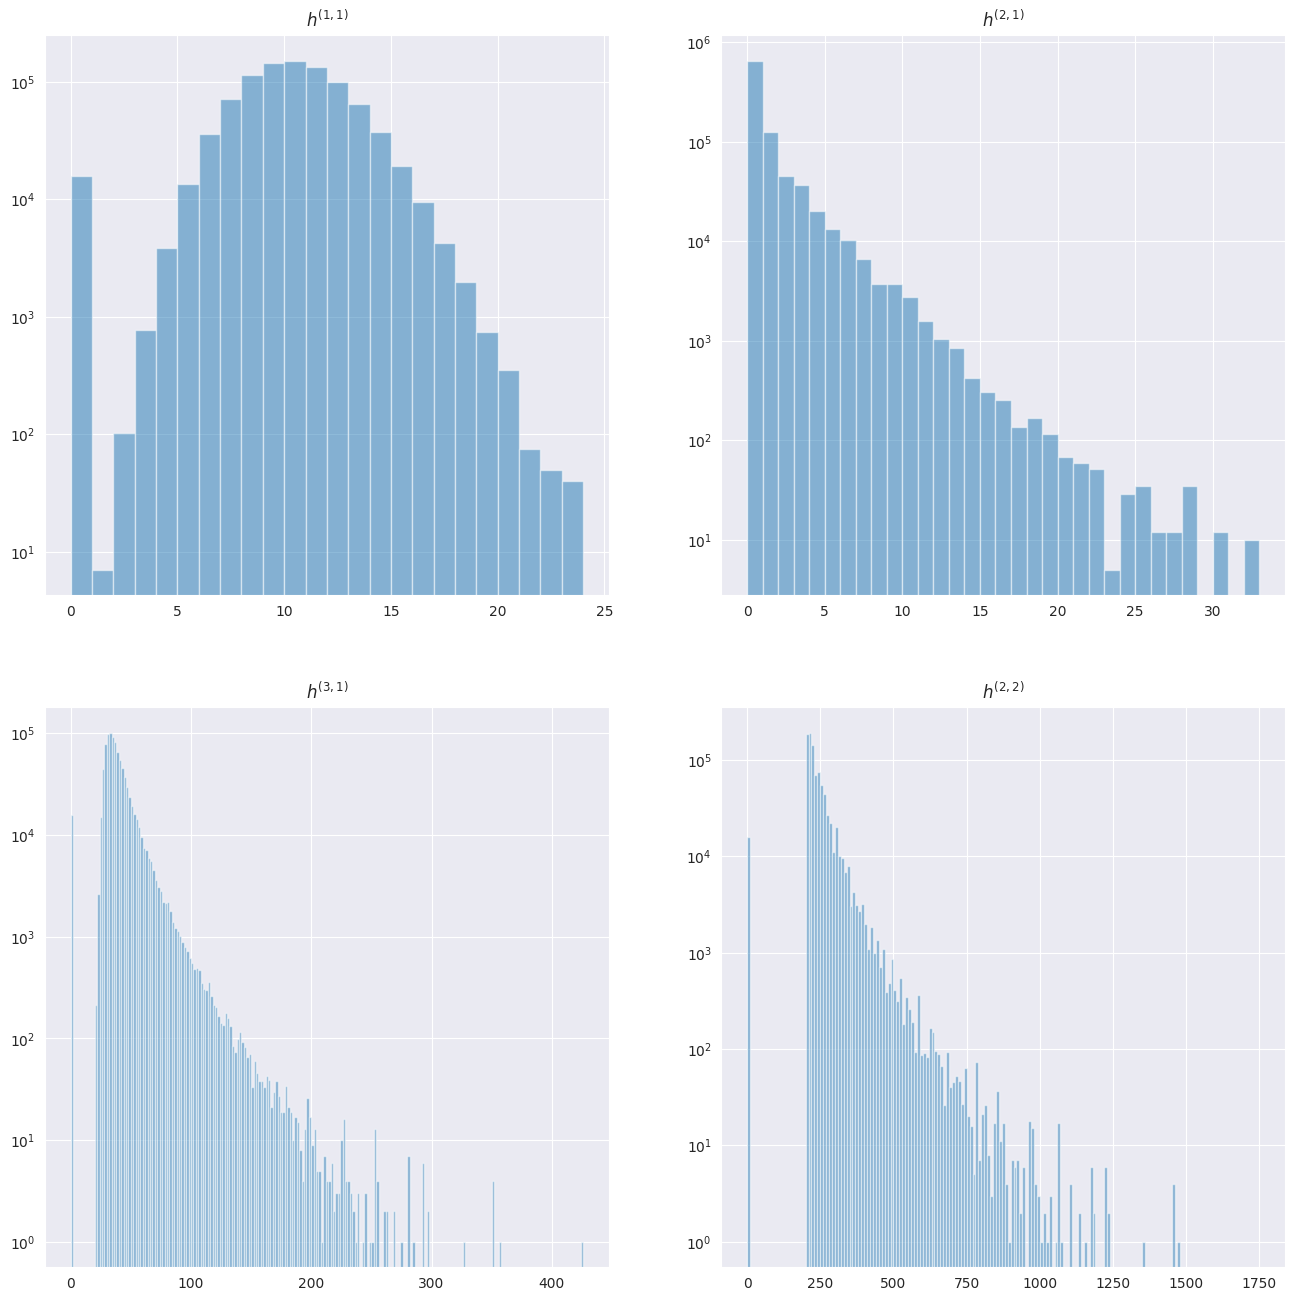

In [4]:
fig, ax = plt.subplots(2,2, figsize = (16,16))
ax[0,0].hist(hodge[:,0], bins=range(h11min, h11max+1), alpha=0.5)
ax[0,0].set_title('$h^{(1,1)}$')
#ax[0,0].ylabel('count')
ax[0,0].set_yscale('log')

ax[0,1].hist(hodge[:,1], bins=range(h21min, h21max+1), alpha=0.5)
ax[0,1].set_title('$h^{(2,1)}$')
#ax[0,0].ylabel('count')
ax[0,1].set_yscale('log')

ax[1,0].hist(hodge[:,2], bins=range(h31min, h31max+1, 2), alpha=0.5)
ax[1,0].set_title('$h^{(3,1)}$')
#ax[0,0].ylabel('count')
ax[1,0].set_yscale('log')

ax[1,1].hist(hodge[:,3], bins=range(h22min, h22max+1,10), alpha=0.5)
ax[1,1].set_title('$h^{(2,2)}$')
#ax[0,0].ylabel('count')
ax[1,1].set_yscale('log')

## Learning Rate Scheduler

https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling#4.-MultiStepLR

https://machinelearningmastery.com/using-learning-rate-schedule-in-pytorch-training/

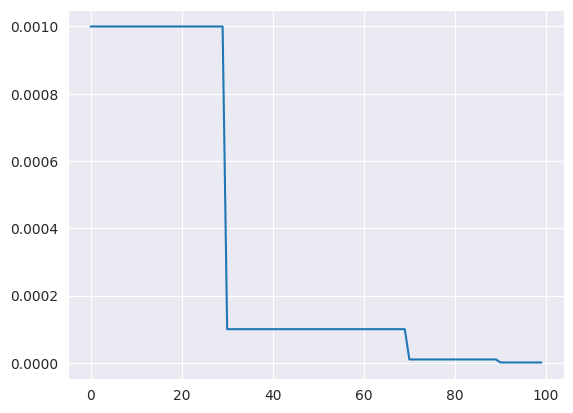

In [5]:
#STEP SCHEDULER
# Test with a dummy model
model_dummy = torch.nn.Linear(2, 1)
optimizer_dummy = torch.optim.SGD(model_dummy.parameters(), lr=0.001)
scheduler_dummy = torch.optim.lr_scheduler.MultiStepLR(optimizer_dummy,
                                                 milestones=[30,70,90], 
                                                 gamma=0.1)
lrs = []

for i in range(100):
    optimizer_dummy.step()
    #print(optimizer_dummy.param_groups[0])
    lrs.append(optimizer_dummy.param_groups[0]["lr"])
    scheduler_dummy.step()

plt.plot(range(100),lrs)


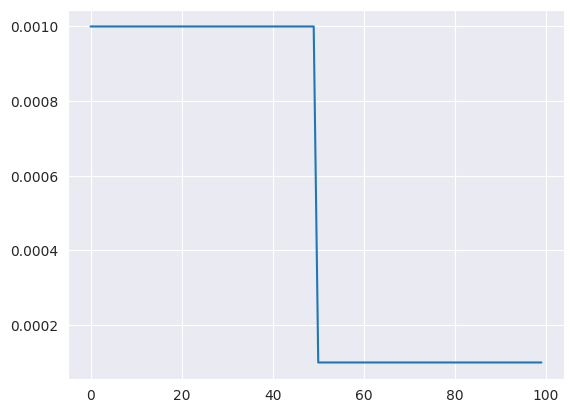

In [6]:
#STEP SCHEDULER
# Test with a dummy model
model_dummy = torch.nn.Linear(2, 1)
optimizer_dummy = torch.optim.SGD(model_dummy.parameters(), lr=0.001)
scheduler_dummy  = lr_scheduler.StepLR(optimizer_dummy,
                                       step_size=50, gamma=0.1)
lrs = []

for i in range(100):
    optimizer_dummy.step()
    #print(optimizer_dummy.param_groups[0])
    lrs.append(optimizer_dummy.param_groups[0]["lr"])
    scheduler_dummy.step()

plt.plot(range(100),lrs)

# Training loop with learning rate scheduler

https://machinelearningmastery.com/using-learning-rate-schedule-in-pytorch-training/

In [7]:

################## TRAINING LOOP #####################
def batch_gd_scheduler(model, criterion, optimizer, train_gen, test_gen, scheduler, 
             epochs, device, batch_size=128,  cnn = False):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)
  model.train()

  for i in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, target in train_gen():
        if cnn:
            inputs = inputs.view(batch_size,1,16,20)
        inputs, target = inputs.to(device), target.to(device)

        optimizer.zero_grad()
        out = model(inputs)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step() 
        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)

    test_loss = []
    for inputs, target in test_gen():
        if cnn:
            inputs = inputs.view(batch_size,1,16,20)
        inputs, target = inputs.to(device), target.to(device)
        out = model(inputs)
        loss = criterion(out, target)
        test_loss.append(loss.item())
        
    test_loss = np.mean(test_loss) 
    train_losses[i] = train_loss
    test_losses[i] = test_loss
    
    #Apply scheduler after the train+validate parts
    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step(test_loss)
    after_lr = optimizer.param_groups[0]["lr"]

    dt = datetime.now()-t0
    print(f'Epoch: {i+1}/{epochs}, train loss: {train_loss: .4f}\
          test_loss: {test_loss: .4f}, duration: {dt}, \
          learning rate: {before_lr, after_lr}')
  return train_losses, test_losses

# Import predefined functions and prepare data

In [8]:
import sys
sys.path.append('/kaggle/input/calabi-yau-cicy-4-folds')
from CICY4_functions import data_generator, batch_gd,  calc_accuracy

In [9]:
from sklearn.model_selection import train_test_split

def train_test(X, y):
    X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101, shuffle = True)
    
    X_train = torch.from_numpy(X_train.astype(np.float32))
    #only need reshape if the y dimension is 1
    #y_train = torch.from_numpy(y_train.astype(np.float32).reshape(-1, 1))
    y_train = torch.from_numpy(y_train.astype(np.float32))

    X_test = torch.from_numpy(X_test.astype(np.float32))
    #y_test = torch.from_numpy(y_test.astype(np.float32).reshape(-1, 1))
    y_test = torch.from_numpy(y_test.astype(np.float32))                         
    
    print(f'X_train shape: {X_train.shape}, \n y_train shape:{y_train.shape},\
                 \n X_test shape: {X_test.shape}, \n y_test shape:{y_test.shape}')
    return X_train, X_test, y_train, y_test

In [10]:
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
y = np.zeros((921497,4))
y[:,0] = h11
y[:,1] = h21
y[:,2] = h31
y[:,3] = h22

In [13]:
y.shape, np.array_equal(y[:,0],h11)

((921497, 4), True)

In [14]:
X_train, X_test, y_train, y_test = train_test(X, y)

X_train shape: torch.Size([737197, 16, 20]), 
 y_train shape:torch.Size([737197, 4]),                 
 X_test shape: torch.Size([184300, 16, 20]), 
 y_test shape:torch.Size([184300, 4])


In [15]:
train_gen = lambda: data_generator(X_train, y_train)
test_gen = lambda: data_generator(X_test, y_test)

In [16]:
def plot_losses(train_losses, test_losses):
    # Plot the train loss and test loss per iteration
    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='test loss')
    plt.legend()
    plt.show()

In [17]:
################## ACCURACY CALCULATION #####################
def calc_accuracy_mr(model, train_gen, test_gen, device, cnn = False):
    model.eval()
    n_correct_h11 = 0.
    n_total_h11 = 0.
    n_correct_h21 = 0.
    n_total_h21 = 0.
    n_correct_h31 = 0.
    n_total_h31 = 0.
    n_correct_h22 = 0.
    n_total_h22 = 0.
    
    batch_size =128
    
    for inputs, target in train_gen():
        if cnn:
            inputs = inputs.view(batch_size,1,16,20)
        inputs, target = inputs.to(device), target.to(device)
        #Perform the prediction
        #round up the prediction to the nearest integer
        ypred = torch.round(model(inputs))
        yp_h11 = ypred[:,0]
        yp_h21 = ypred[:,1]
        yp_h31 = ypred[:,2]
        yp_h22 = ypred[:,3]
        tg_h11 = target[:,0]
        tg_h21 = target[:,1]
        tg_h31 = target[:,2]
        tg_h22 = target[:,3]
        # update counts
        n_correct_h11 += (yp_h11 == tg_h11).sum().item()
        n_total_h11 += tg_h11.shape[0]
        n_correct_h21 += (yp_h21 == tg_h21).sum().item()
        n_total_h21 += tg_h21.shape[0]
        n_correct_h31 += (yp_h31 == tg_h31).sum().item()
        n_total_h31 += tg_h31.shape[0]
        n_correct_h22 += (yp_h22 == tg_h22).sum().item()
        n_total_h22 += tg_h22.shape[0]
    train_acc_h11 = n_correct_h11 / n_total_h11
    train_acc_h21 = n_correct_h21 / n_total_h21
    train_acc_h31 = n_correct_h31 / n_total_h31
    train_acc_h22 = n_correct_h22 / n_total_h22
    
    #TEST SET
    n_correct_h11 = 0.
    n_total_h11 = 0.
    n_correct_h21 = 0.
    n_total_h21 = 0.
    n_correct_h31 = 0.
    n_total_h31 = 0.
    n_correct_h22 = 0.
    n_total_h22 = 0.
    for inputs, target in test_gen():
        if cnn:
            inputs = inputs.view(batch_size,1,16,20)
        inputs, target = inputs.to(device), target.to(device)
        
        # Forward pass
        ypred = torch.round(model(inputs))
        yp_h11 = ypred[:,0]
        yp_h21 = ypred[:,1]
        yp_h31 = ypred[:,2]
        yp_h22 = ypred[:,3]
        tg_h11 = target[:,0]
        tg_h21 = target[:,1]
        tg_h31 = target[:,2]
        tg_h22 = target[:,3]
        # update counts
        n_correct_h11 += (yp_h11 == tg_h11).sum().item()
        n_total_h11 += tg_h11.shape[0]
        n_correct_h21 += (yp_h21 == tg_h21).sum().item()
        n_total_h21 += tg_h21.shape[0]
        n_correct_h31 += (yp_h31 == tg_h31).sum().item()
        n_total_h31 += tg_h31.shape[0]
        n_correct_h22 += (yp_h22 == tg_h22).sum().item()
        n_total_h22 += tg_h22.shape[0]
    test_acc_h11 = n_correct_h11 / n_total_h11
    test_acc_h21 = n_correct_h21 / n_total_h21
    test_acc_h31 = n_correct_h31 / n_total_h31
    test_acc_h22 = n_correct_h22 / n_total_h22
    
    train_acc = [train_acc_h11,train_acc_h21,train_acc_h31,train_acc_h22]
    test_acc = [test_acc_h11,test_acc_h21,test_acc_h31,test_acc_h22]

    return train_acc, test_acc

# RNN model with GRU layers

In [18]:
class RNN_cicy4(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN_cicy4,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers        
        #self.lstm = nn.LSTM(input_size = self.D,
        #                   hidden_size = self.M,
        #                   num_layers = self.L,
        #                   batch_first = True)    
        self.gru = nn.GRU(input_size = self.D,
                           hidden_size = self.M,
                           num_layers = self.L,
                           batch_first = True)
        self.fc1 = nn.Linear(self.M, 128)
        self.fc2 = nn.Linear(128, self.K)
       
    def forward(self, X):
        #input X is NxTxD
        #initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        #c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        #get LSTM unit output:
        #output is NxTxM
        #out, _ = self.lstm(X, (h0,c0))
        out, _ = self.gru(X, h0)   
        #we only want h(T) at the final time step
        out = out[:, -1, :]
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [19]:
#( n_inputs, n_hidden, n_rnnlayers, n_outputs)
# n_inputs = D = # of columns: 20, T = 16
#input shape is NxTxD: Nx16x20
#model = RNN_cicy4(20, 128, 10, 4)
model = RNN_cicy4(20, 100, 8, 4)
model.to(device)

RNN_cicy4(
  (gru): GRU(20, 100, num_layers=8, batch_first=True)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [20]:
#count the number of parameters in the model
params = [p.numel() for p in model.parameters() if p.requires_grad]
print(sum(params))

474244


In [21]:
X = X_train[0].to(device)
y = y_train[0].to(device)
print(f'Original shape of the image before passing through the network: \n {X.shape}\n')

print('Reshape the size to take in account the batch number')
X = X.view(1,16,20)
print(f'The new size is {X.shape}\n')

h0 = torch.zeros(model.L, X.size(0), model.M).to(device)
c0 = torch.zeros(model.L, X.size(0), model.M).to(device)
X, _ = model.gru(X, h0)
print(f'Shape of the image after passing through the {model.gru}: \n {X.shape}\n')

X = model.fc1(X[:,-1,:])
print(f'Shape of the image after passing through the {model.fc1}: \n {X.shape}\n')

X = model.fc2(X)
print(f'Shape of the image after passing through the {model.fc2}: \n {X.shape}\n')
 
print(X)
print(f'Target: {y}')

Original shape of the image before passing through the network: 
 torch.Size([16, 20])

Reshape the size to take in account the batch number
The new size is torch.Size([1, 16, 20])

Shape of the image after passing through the GRU(20, 100, num_layers=8, batch_first=True): 
 torch.Size([1, 16, 100])

Shape of the image after passing through the Linear(in_features=100, out_features=128, bias=True): 
 torch.Size([1, 128])

Shape of the image after passing through the Linear(in_features=128, out_features=4, bias=True): 
 torch.Size([1, 4])

tensor([[ 0.0370,  0.0599,  0.0210, -0.0343]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Target: tensor([ 11.,   0.,  34., 224.], device='cuda:0')


In [22]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[70,90,120], gamma=0.1)
#https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [23]:
train_losses, test_losses=batch_gd_scheduler(model, criterion, optimizer, train_gen, test_gen, scheduler, 
                                             250, device,  cnn=False)

Epoch: 1/250, train loss:  1095.2429          test_loss:  904.4972, duration: 0:00:35.267365,           learning rate: (0.001, 0.001)
Epoch: 2/250, train loss:  906.4757          test_loss:  904.0781, duration: 0:00:34.768601,           learning rate: (0.001, 0.001)
Epoch: 3/250, train loss:  815.0117          test_loss:  672.1582, duration: 0:00:34.944857,           learning rate: (0.001, 0.001)
Epoch: 4/250, train loss:  514.4637          test_loss:  407.1011, duration: 0:00:35.058819,           learning rate: (0.001, 0.001)
Epoch: 5/250, train loss:  340.2297          test_loss:  337.3814, duration: 0:00:34.889112,           learning rate: (0.001, 0.001)
Epoch: 6/250, train loss:  221.0320          test_loss:  174.9757, duration: 0:00:35.007991,           learning rate: (0.001, 0.001)
Epoch: 7/250, train loss:  159.6403          test_loss:  126.5911, duration: 0:00:34.932163,           learning rate: (0.001, 0.001)
Epoch: 8/250, train loss:  127.5130          test_loss:  108.0424, d

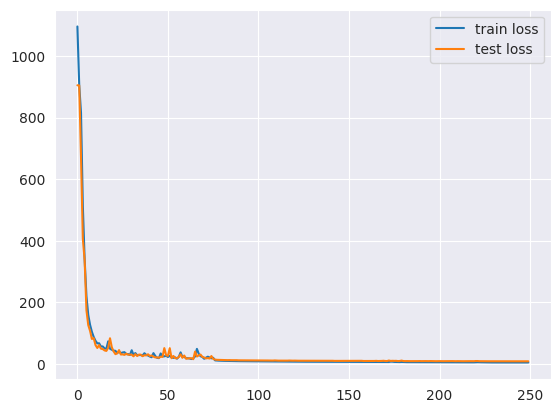

In [24]:
plot_losses(train_losses, test_losses)

In [25]:
train_acc, test_acc = calc_accuracy_mr(model, train_gen , test_gen, device = device, cnn= False)
print(f'Train accuracy for h11:{train_acc[0]:.4f}, Test accuracy for h11: {test_acc[0]:.4f}')
print(f'Train accuracy for h21:{train_acc[1]:.4f}, Test accuracy for h21: {test_acc[1]:.4f}')
print(f'Train accuracy for h31:{train_acc[2]:.4f}, Test accuracy for h31: {test_acc[2]:.4f}')
print(f'Train accuracy for h22:{train_acc[3]:.4f}, Test accuracy for h22: {test_acc[3]:.4f}')

Train accuracy for h11:0.7202, Test accuracy for h11: 0.7195
Train accuracy for h21:0.6606, Test accuracy for h21: 0.6564
Train accuracy for h31:0.3886, Test accuracy for h31: 0.3659
Train accuracy for h22:0.1638, Test accuracy for h22: 0.1545


In [26]:
torch.save(model, '/kaggle/working/saved_models/GRU_cicy4_Hodge_v5.pt')